# 6. Kernel Methods

### *Table of Contents*

* 6.1 [Dual Representations](#6.1-Dual-Representations)
* 6.2 [Constructing Kernels](#6.2-Constructing-Kernels)
* 6.3 [Radial Basis Function Networks](#6.3-Radial-Basis-Function-Networks)
* 6.4 [Gaussian Processes](#6.4-Gaussian-Processes)
    * 6.4.2 [Gaussian processes for regression](#6.4.2-Gaussian-processes-for-regression)
    * 6.4.3 [Learning the hyperparameters](#6.4.3-Learning-the-hyperparameters)
    * 6.4.4 [Automatic relevance determination](#6.4.4-Automatic-relevance-determination)
    * 6.4.5 [Gaussian process for classification](#6.4.5-Gaussian-process-for-classification)
    * 6.4.7 [Connection to neural networks](#6.4.7-Connection-to-neural-networks)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from prml.preprocessing import PolynomialFeature, GaussianFeature, SigmoidFeature
from prml.distribution import MultivariateGaussian
from prml.kernel import RBF, GaussianProcessRegression
from prml.datasets import generate_toy_data

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%reload_ext autoreload
%autoreload 2

In [Chapter 3](ch3_linear_models_for_regression.ipynb) and [4](ch4_linear_models_for_classification.ipynb), we considered linear parametric models governed by a vector $\mathbf{w}$ of adaptive parameters. During the learning phase, a set of training data is used to obtain a point estimate of the parameter vector or determine their posterior distribution. Then, the training set may be discarded and predictions are based only on the learned parameters. The same approach is employed for non-linear models such as neural networks.

However, there is a class of techniques, in which the training data are kept and used also in the prediction phase. For instance, *memory-based* methods, such as Parzen density models and nearest-neighbors, store the entire training set in order to make predictions for future data points. These methods typically require a metric that measures the similarity of any pair of vectors in the input space. They are generally fast to train, because they just store the training data, and slow at making predictions, because they have to pass over the training set, possibly multiple times.

Interestingly, many linear parametric models can be re-cast into an equivalent *dual representation* in which the predictions are also based on linear combinations of a *kernel function* evaluated on the training data points. Assuming models based on a fixed nonlinear *feature space* mapping $\boldsymbol\phi(\mathbf{x})$, the kernel function is defined by

$$
k(\mathbf{x},\mathbf{x}') = \boldsymbol\phi(\mathbf{x})^T\boldsymbol\phi(\mathbf{x}')
$$

where the kernel is a symmetric function of its arguments $k(\mathbf{x},\mathbf{x}')=k(\mathbf{x}',\mathbf{x})$. To that end, the simplest example of a kernel function is obtained by considering the identity feature mapping, which is $\boldsymbol\phi(\mathbf{x})=\mathbf{x}$, and thus $k(\mathbf{x},\mathbf{x}')=\mathbf{x}^T\mathbf{x}'$ is referred as the **linear kernel**.

The concept of a kernel formulated as an inner product in a feature space allows us to build interesting extensions of well-known algorithms by making use of the *kernel trick*, also known as *kernel substitution*. The idea is to replace the scalar product of the input vector $\mathbf{x}$ in the formulation of interest with any kernel.

> One of the most significant developments has been the extension of kernels to handle symbolic objects.

## 6.1 Dual Representations

Consider a linear regression model whose parameters are determined by minimizing the regularized sum-of-squares error function given by

$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w}
$$

If we set the gradient of $E(\mathbf{w})$ with respect to $\mathbf{w}$ equal to zero, then, the solution for $\mathbf{w}$ takes the form of a linear combination of the vectors $\boldsymbol\phi(\mathbf{x}_n)$, with coefficients $a_n$ that are functions of $\mathbf{w}$,

$$
\begin{aligned}
\nabla E(\mathbf{w}) = \mathbf{0} & \Leftrightarrow 
\nabla\frac{1}{2}\sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w} = \mathbf{0} \\
& \Leftrightarrow \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) + \lambda\mathbf{w} = \mathbf{0} \\
& \Leftrightarrow \lambda\mathbf{w} = - \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) \\
& \Leftrightarrow \mathbf{w} = - \frac{1}{\lambda} \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) \\
& \Leftrightarrow \mathbf{w} = \sum_{n=1}^N a_n\boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

where $a_n =  -\frac{1}{\lambda}\big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)$. Then, using a ($N\times M$) design matrix $\boldsymbol\Phi$, whose nth row is given by $\boldsymbol\phi(\mathbf{x}_n)^T$, and $a = (a_1,\dots,a_N)^T$, we obtain

$$
\mathbf{w} = \boldsymbol\Phi^T\mathbf{a}
$$

The dual representation is obtained if instead of working with the parameter vector $\mathbf{w}$, we reformulate the least-squares algorithm in terms of the parameter vector $\mathbf{a}$. If we substitute $\mathbf{w} = \boldsymbol\Phi^T\mathbf{a}$ into $E(\mathbf{w})$, we obtain,

$$
\begin{aligned}
E(\mathbf{a}) &= \frac{1}{2}\sum_{n=1}^N \big(\mathbf{a}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2} \Big|\Big| \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T - \mathsf{t} \Big|\Big|_2^2 + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2} \Big( \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} - 2\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathsf{t} + \mathsf{t}^T\mathsf{t} \Big) + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} - \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a}
\end{aligned}
$$

By defining the *Gram* matrix $\mathbf{K} = \boldsymbol\Phi\boldsymbol\Phi^T$, which is a symmetric $N \times N$ matrix with elements, $K_{nm} = k(x_n, x_m) = \boldsymbol\phi(x_n)^T\boldsymbol\phi(x_m)$, where $k$ is a kernel function, the sum-of-squares error function can be written as,

$$
E(\mathbf{a}) = \frac{1}{2}\mathbf{a}^T\mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{a}^T\mathbf{K}\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\mathbf{K}\mathbf{a}
$$

If we set the gradient of $E(\mathbf{a})$ equal to zero, then, we obtain the following solution,

$$
\begin{aligned}
\nabla E(\mathbf{a}) = \mathbf{0} & \Leftrightarrow 
\nabla \frac{1}{2}\mathbf{a}^T\mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{a}^T\mathbf{K}\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\mathbf{K}\mathbf{a} = 
\mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{K}\mathsf{t} + \mathbf{K}\mathbf{a} = \mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) - \mathbf{K}\mathsf{t} = \mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) = \mathbf{K}\mathsf{t} \\
& \Leftrightarrow \mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) = \mathsf{t} \\
& \Leftrightarrow \mathbf{a} = (\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t}
\end{aligned}
$$

By substituting this back into the linear regression model, we obtain,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}) = \mathbf{a}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}) = 
\boldsymbol\Phi\boldsymbol\phi(\mathbf{x})(\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t} = 
\mathbf{k}(\mathbf{x})^T(\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t}
$$

where $\mathbf{k}(\mathbf{x})^T = [k(\mathbf{x}_1, \mathbf{x}),\dots,k(\mathbf{x}_N, \mathbf{x})] = [\boldsymbol\phi(\mathbf{x}_1)^T\boldsymbol\phi(\mathbf{x}),\dots,\boldsymbol\phi(\mathbf{x}_N)^T\boldsymbol\phi(\mathbf{x})]$

Therefore, the dual formulation allows the solution to the least-squares problem to be expressed entirely in terms of a kernel function. 

> **NOTE:** In the dual formulation, we determine the parameter vector a by inverting an $N \times N$ matrix, whereas in the original parameter space formulation, we had to invert an $M \times M$ matrix in order to determine $\mathbf{w}$. Because $N$ is typically much larger than $M$, the dual formulation does not seem to be particularly useful. However, theadvantage of the dual formulation is that it is expressed entirely in terms of the kernel function $k(\mathbf{x}, \mathbf{x}')$. Therefore, we work directly in terms of kernels and avoid the explicit introduction of the feature vector $\boldsymbol\phi(\mathbf{x})$, which allows us to use feature spaces of high, even infinite, dimensionality.

In fact, the existence of a dual representation based on the Gram matrix is a property of many linear models. For instance, let's develop the same representation for the Perceptron algorithm. The update rule for the Perceptron is as follows,

$$
\mathbf{w}^{\tau+1} = \mathbf{w}^{\tau} + \eta\boldsymbol\phi(\mathbf{x}_n)t_n 
$$

Assuming $\mathbf{w}^0 = \mathbf{0}$, then

$$
\begin{aligned}
\mathbf{w}^{(1)} &= \eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
\mathbf{w}^{(2)} &= 2\eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
&\dots \\
\mathbf{w}^{(\tau)} &= \tau\eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
\mathbf{w}^{(\tau+1)} &= (\tau+1)\eta\boldsymbol\phi(\mathbf{x}_n)t_n
\end{aligned}
$$

or

$$
\mathbf{w} = \sum_{n=1}^N \eta c_n t_n \boldsymbol\phi(\mathbf{x}_n) = \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)
$$

By substituting $\mathbf{w}$ back to the original update formula, we obtain,

$$
\begin{aligned}
\sum_{n=1}^N a_n^{(\tau+1)} t_n \boldsymbol\phi(\mathbf{x}_n) &= \sum_{n=1}^N a_n^{(\tau)} t_n \boldsymbol\phi(\mathbf{x}_n) + \eta t_n \boldsymbol\phi(\mathbf{x}_n) \Leftrightarrow \\
\sum_{n=1}^N a_n^{(\tau+1)} &= \sum_{n=1}^N a_n^{(\tau)} + \eta
\end{aligned}
$$

In other words, the update process is to add learning rate $\eta$ to the coefficient $a_n$, corresponding to input $\mathbf{x}_n$. Finally, substituting back to the linear model, we obtain,

$$
y(\mathbf{x}) = f(\mathbf{w}^T\boldsymbol\phi(\mathbf{x})) = f\Big(\sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)^T\boldsymbol\phi(\mathbf{x})\Big) = 
f\Big(\sum_{n=1}^N a_n t_n k(\mathbf{x}_n, \mathbf{x})\Big)
$$


## 6.2 Constructing Kernels

One approach is to choose a feature space mapping $\boldsymbol\phi(\mathbf{x})$, e.g., polynomials, gaussian etc, and then use it to find the corresponding kernel.

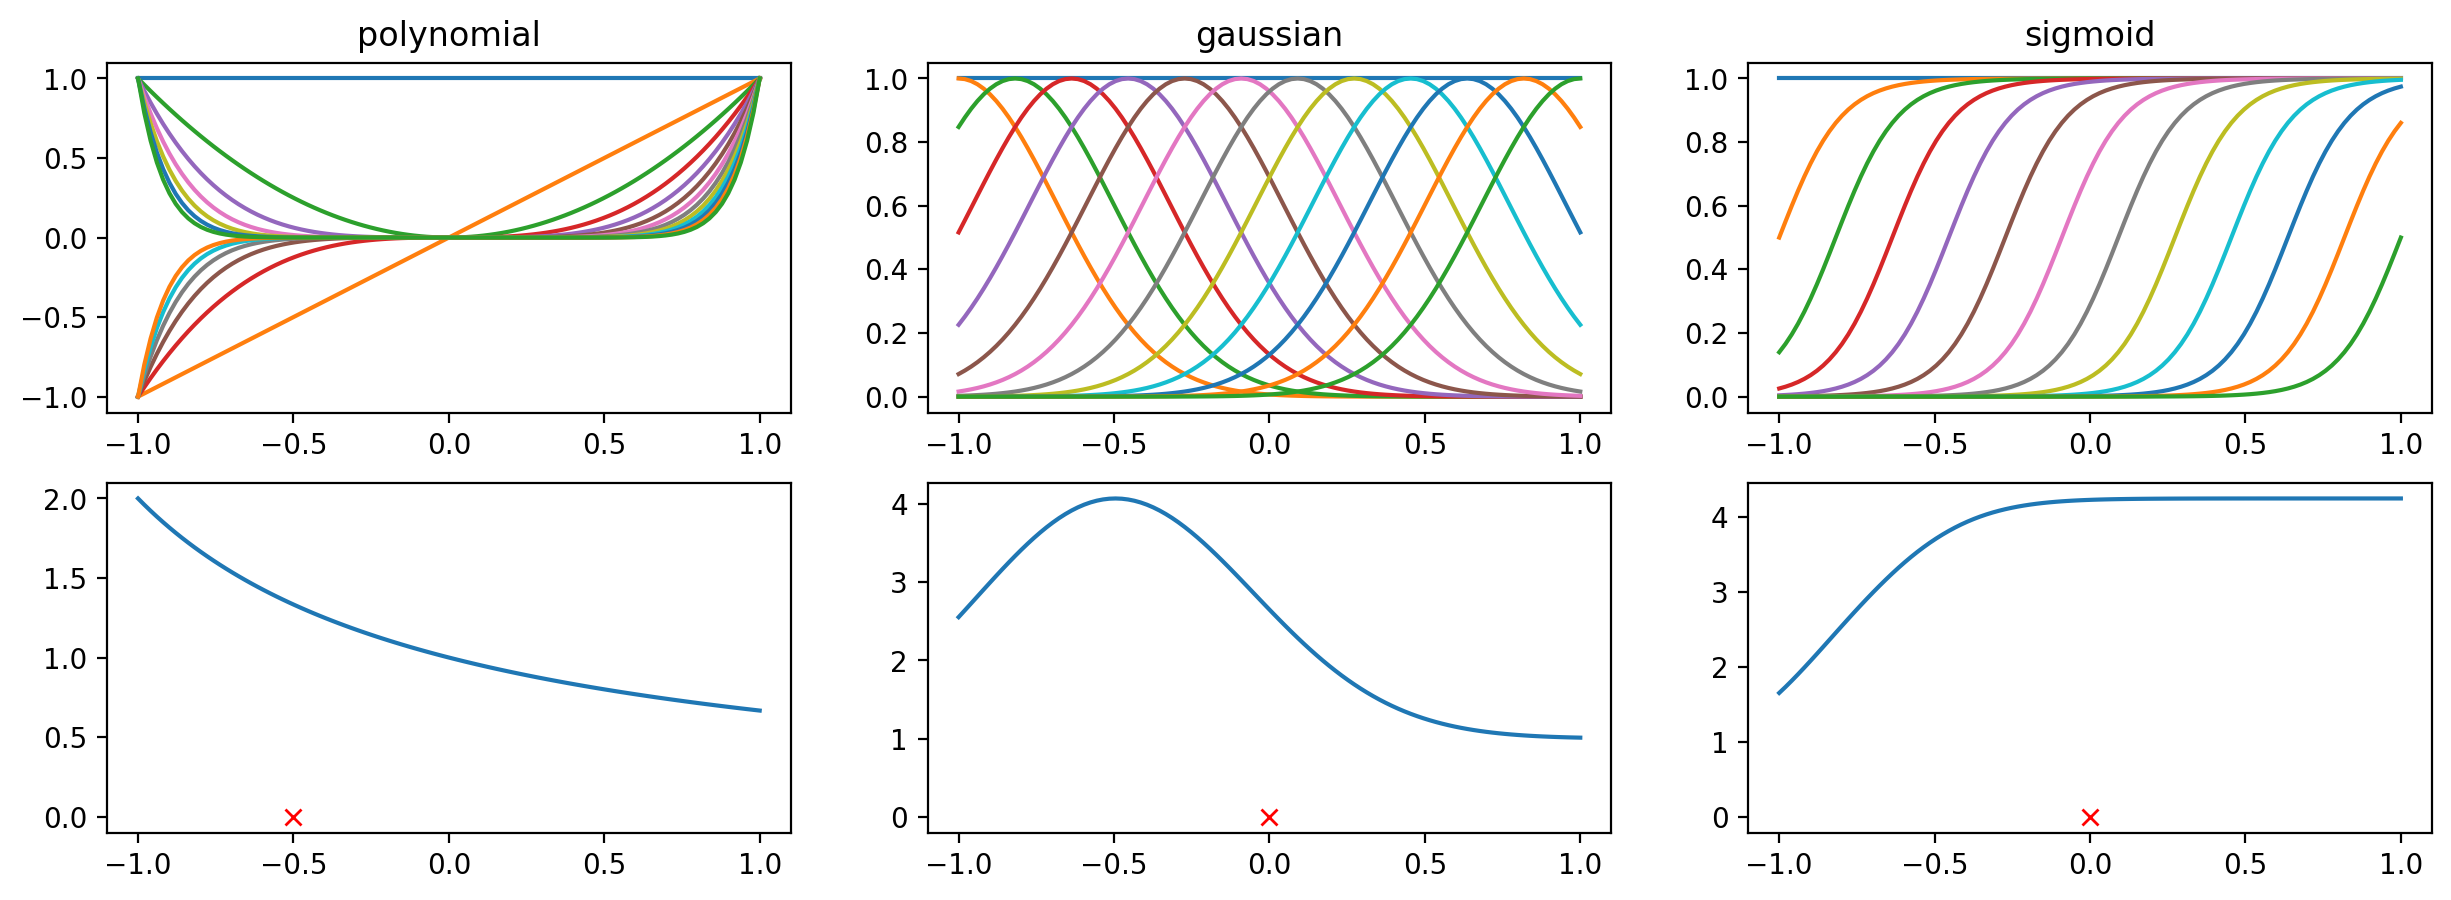

In [45]:
x_space = np.linspace(-1, 1, 100)

# Create 12 degree polynomial basis functions
polynomial = PolynomialFeature(degree=12)

# Create 12 Gaussian basis functions
gaussian = GaussianFeature(mean=np.linspace(-1, 1, 12), sigma=0.1)

# Create 12 sigmoid basis functions
sigmoid = SigmoidFeature(mean=np.linspace(-1, 1, 12), sigma=0.1)

plt.figure(figsize=(15, 5))
for i, phi in enumerate([polynomial, gaussian, sigmoid]):
    x = phi.transform(x_space)

    plt.subplot(2, 3, i + 1)
    for j in range(x.shape[1]):
        plt.plot(x_space, x[:, j])
    plt.title(phi.__class__.__name__.removesuffix("Feature").lower())

    plt.subplot(2, 3, i + 4)
    plt.plot(0, 0, "rx") if i > 0 else plt.plot(-0.5, 0, "rx")
    plt.plot(x_space, x @ phi.transform(-0.5).T)

plt.show()

Another approach is to construct kernel functions directly. In order to exploit kernel substitution, we need to be able to construct valid kernel functions, or in other words kernels that correspond to a scalar product in some (perhaps infinite dimensional) feature space. Consider for instance, a kernel function given by $k(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z})^2$. Expanding the terms, we can thereby identify the corresponding nonlinear feature mapping,

$$
\begin{aligned}
k(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z})^2 &= (x_1z_1 + x_2z_2 + \dots + x_Nz_N)^2 \\
&= \sum_{n=1}^N x_n^2z_n^2 + 2\sum_{n=1}^N\sum_{m=1}^{n-1} x_nz_nx_mz_m \\
&= (x_1^2, \sqrt{2}x_1x_2, \dots, x_N^2)(z_1^2, \sqrt{2}z_1z_2, \dots, z_N^2)^T \\
&= \boldsymbol\phi(\mathbf{x})^T\boldsymbol\phi(\mathbf{z})
\end{aligned}
$$

One standard technique for constructing kernels is to build them out of simpler kernels as building blocks. This can be done using the properties $(6.13)$ to $(6.22)$ appearing in the book. In general, the kernel should be symmetric and positive semidefinite and express the appropriate form of similarity between $\mathbf{x}$ and $\mathbf{x}'$.

A commonly used kernel is the Gaussian kernel, which takes the form,

$$
k(\mathbf{x}, \mathbf{z}) = \exp(-||\mathbf{x} - \mathbf{z}||^2 / 2\sigma^2)
$$

> In this context, it is not interpreted as a probability density, and hence the normalization coefficient is omitted.

By expanding the square we obtain,

$$
||\mathbf{x} - \mathbf{z}||^2 = \mathbf{x}^T\mathbf{z} - 2\mathbf{x}^T\mathbf{z} + (\mathbf{z})^T\mathbf{z}
$$

thus,

$$
\exp(-(\mathbf{x}^T\mathbf{x} - 2\mathbf{x}^T\mathbf{z} + (\mathbf{z})^T\mathbf{z}) / 2\sigma^2) = 
\exp(-\mathbf{x}^T\mathbf{x} / 2\sigma^2) + \exp(\mathbf{x}^T\mathbf{z} / \sigma^2) + \exp(-\mathbf{z}^T\mathbf{z} / 2\sigma^2)
$$

which is a valid kernel due to $(6.14)$ and $(6.16)$ and the fact that the linear kernel is valid. Note that the Gaussian kernel is not restricted to Euclidean distance. If we use
kernel substitution to replace $\mathbf{x}^T\mathbf{z}$ with a nonlinear kernel $\kappa(\mathbf{x}, \mathbf{z})$, we obtain

$$
k(\mathbf{x}, \mathbf{z}) = \exp\Big(-\frac{1}{2\sigma^2}\big(\kappa(\mathbf{x},\mathbf{x}) - 2\kappa(\mathbf{x},\mathbf{z}) + \kappa(\mathbf{z},\mathbf{z})\big)\Big) = 
$$

Kernel functions may also be defined over generic objects, as diverse as graphs, sets, strings, and text documents. Consider, for instance, a set and define a non-vectorial space consisting of all possible subsets. If $A_1$ and $A_2$ are two such subsets, then one simple choice of kernel would be,

$$
k(A_1, A_2) = 2^{|A_1 \cap A_1|}
$$

## 6.3 Radial Basis Function Networks

Radial basis functions have the property that each basis function depends only on the radial distance (typically Euclidean) from a centre $\boldsymbol\mu_j$, so that $\boldsymbol\phi_j(\mathbf{x}) = h(||\mathbf{x} - \boldsymbol\mu_j||)$. Historically, radial basis functions were introduced for the purpose of exact function interpolation, which is achieved by expressing $f(\mathbf{x})$ as a linear combination of radial basis functions, one centred on every data point. Then, the parameters $\mathbf{w}$ are found by least squares, and because there are the same number of parameters as there are constraints (data points), the resulted function fits every target value exactly. In machine learning applications, however, the target values are generally noisy, and exact interpolation is undesirable (over-fitting). Moreover, because there is one basis function associated with every data point, the corresponding model can be computationally costly to evaluate when making predictions for new data points.

> One way of choosing the basis function centres is to randomly chose a subset of the data points. A more systematic approach is to use orthogonal least squares, a sequential selection process, in which, at each step the next data point to be chosen as a basis function centre corresponds to the one that gives the greatest reduction in the sum-of-squares error. Clustering algorithms such as $k$-means have also been used, which give a set of basis function centres that no longer coincide with training data points.

## 6.4 Gaussian Processes

In order to motivate the Gaussian process viewpoint, let us return to the linear regression example and re-derive the predictive distribution by working in terms of distributions over functions $y(\mathbf{x}, \mathbf{w})$. Consider the model defined in terms of a linear combination of $M$ fixed basis functions given by the elements of the vector $\boldsymbol\phi(\mathbf{x})$ so that,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x})
$$

Then, consider a prior distribution over $\mathbf{w}$ given by an isotropic Gaussian (see also Chapter [3](ch3_linear_models_for_regression.ipynb#3.3.1-Parameter-distribution)) of the form,

$$
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I})
$$

Since, for any given value of $\mathbf{w}$, $y(\mathbf{x})$ defines a particular function of $\mathbf{x}$, the probability distribution over $\mathbf{w}$ induces a probability distribution over functions $y(\mathbf{x})$. For the training data points $\mathbf{x}_1,\dots,\mathbf{x}_N$, we are therefore interested in the joint distribution of the function values $y(\mathbf{x}_1),\dots,y(\mathbf{x}_N)$, or $\mathbf{y} = \boldsymbol\Phi\mathbf{w}$, where $\boldsymbol\Phi$ is the design matrix.

In order to find the probability distribution of $\mathbf{y}$, note that $\mathbf{y}$ is a linear combination of Gaussian distributed variables given by the elements of $\mathbf{w}$ and hence is itself Gaussian. We therefore need only to find its mean and covariance,

$$
E[\mathbf{y}] = E[\boldsymbol\Phi\mathbf{w}] = \boldsymbol\Phi E[\mathbf{w}] = \boldsymbol\Phi\mathbf{0} = \mathbf{0}
$$

and

$$
cov[\mathbf{y}] = E[\mathbf{y}\mathbf{y}^T] = E[\boldsymbol\Phi\mathbf{w}\mathbf{w}^T\boldsymbol\Phi^T] = \boldsymbol\Phi E[\mathbf{w}\mathbf{w}^T]\boldsymbol\Phi^T =
\frac{1}{\alpha}\boldsymbol\Phi\boldsymbol\Phi^T = \mathbf{K}
$$

where $\mathbf{K}$ is the Gram matrix.

> This model provides us with a particular example of a Gaussian process, defined by the linear regression model $(6.49)$ with a weight prior $(6.50)$. In cases where the input vector $\mathbf{x}$ is two dimensional, this is also known as a *Gaussian random field*.

Thus, Gaussian stochastic processes is the joint distribution over $N$ specified completely by the second-order statistics. When, we have no prior knowledge about the mean of $y(\mathbf{x})$ we typically take it to be zero. This is equivalent to choosing the mean of the prior over weight values $p(\mathbf{w})$ to be zero in the basis function viewpoint. The specification of the Gaussian process is then completed by the covariance of $y(\mathbf{x})$ evaluated at any two values of $y(\mathbf{x})$, which is given by the kernel function

$$
E[y(\mathbf{x}_n)y(\mathbf{x}_m)] = \mathbf{K}_{nm} = k(\mathbf{x}_n, \mathbf{x}_m)
$$

Towards defining kernel functions directly for the covariance, two common choices are the Gaussian kernel and the exponetial kernel given by,

$$
k(x, z) = \exp(-\theta|x-z|)
$$

### 6.4.2 Gaussian processes for regression

Recall that the noise on the observed target values for linear regression models may be modelled as,

$$
t_n = y_n + \epsilon_n
$$

where $\epsilon_n$ is a random noise variable whose value is chosen independently for each observation. To that end, the noise processes may be modelled as a Gaussian distribution

$$
p(t_n|y_n) = \mathcal{N}(t_n|y_n,\beta^{-1})
$$

Because the noise is independent for each data point, the joint distribution of the target values is given by an isotropic Gaussian of the form,

$$
p(\mathsf{t}|\mathsf{y}) = \mathcal{N}(\mathsf{t}|\mathsf{y},\beta^{-1}\mathbf{I}_N)
$$

From the definition of a Gaussian process, the marginal distribution $p(\mathsf{y})$ is given by a Gaussian whose mean is zero and whose covariance is defined by a Gram matrix so that,

$$
p(\mathsf{y}) = \mathcal{N}(\mathsf{y}|\mathbf{0},\mathbf{K})
$$

The kernel function that determines $\mathbf{K}$ is typically chosen to express that, for points $\mathbf{x}_n$ and $\mathbf{x}_m$ that are similar, the corresponding values $y(\mathbf{x}_n)$ and $y(\mathbf{x}_m)$ will be more strongly correlated than for dissimilar points. A widely used kernel function for Gaussian process regression is given by the exponential of a quadratic form, and the addition of constant and linear terms to give,

$$
k(\mathbf{x}_n, \mathbf{x}_m) = \theta_0\exp\Big\{ -\frac{\theta_1}{2} ||\mathbf{x}_n - \mathbf{x}_m||^2 \Big\} + \theta_2 + \theta_3\mathbf{x}_n^T\mathbf{x}_m
$$

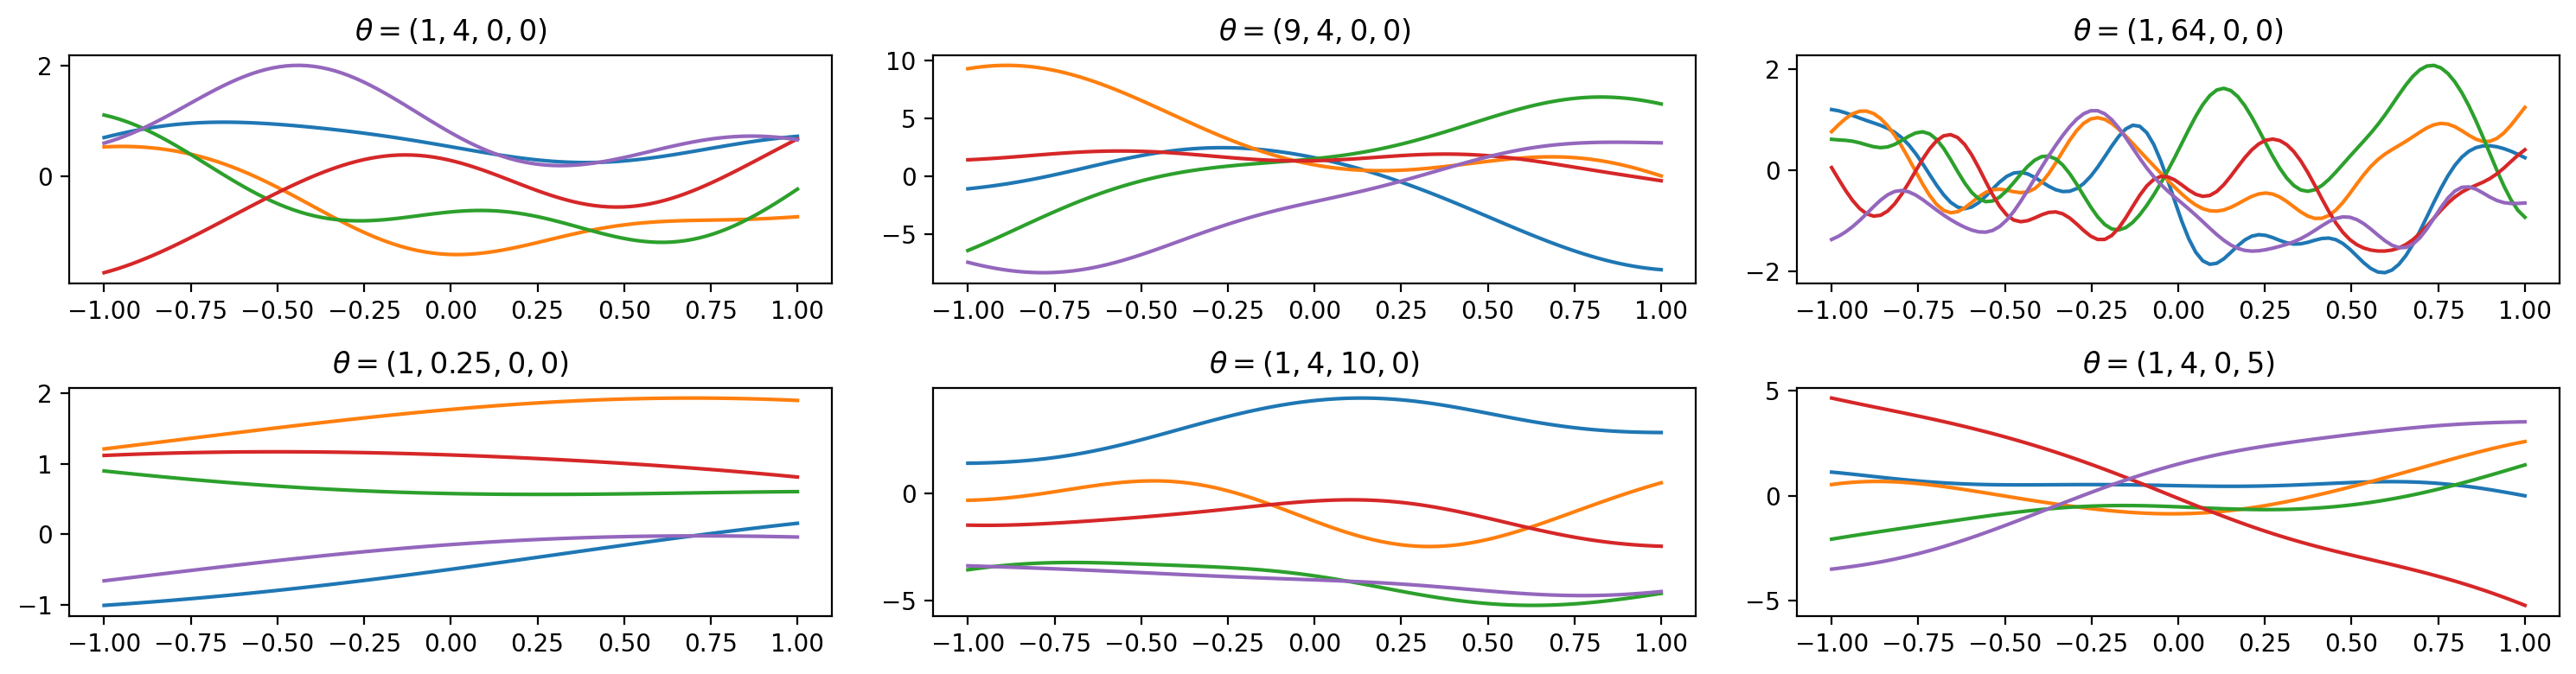

In [147]:
x_space = np.linspace(-1, 1, 100)[:, None]


def K(theta, x):
    N = x.shape[0]
    r = np.zeros((N, N))
    for (i, _), xn in np.ndenumerate(x):
        for (j, _), xm in np.ndenumerate(x):
            r[i][j] = theta[0] * np.exp(-(theta[1] / 2) * np.linalg.norm(xn - xm) ** 2) + theta[2] + theta[3] * xn * xm
    return r


plt.figure(figsize=(15, 4), tight_layout=True)
mu = np.zeros(x_space.shape)
for i, theta in enumerate([(1, 4, 0, 0), (9, 4, 0, 0), (1, 64, 0, 0), (1, 0.25, 0, 0), (1, 4, 10, 0), (1, 4, 0, 5)]):
    prior_gaussian = MultivariateGaussian(mu, K(theta, x_space))
    plt.subplot(2, 3, i + 1)
    plt.plot(x_space, prior_gaussian.draw(5).T)
    plt.title(f"$\\theta={theta}$")

plt.show()

In order to find the marginal distribution p(t), conditioned on the input values
x1, . . . , xN , we need to integrate over y.

$$
p(\mathsf{t}) = \int p(\mathsf{t}|\mathsf{y})p(\mathsf{y}) d\mathsf{y} =
\int \mathcal{N}(\mathsf{t}|\mathsf{y},\beta^{-1}\mathbf{I}_N)\mathcal{N}(\mathsf{y}|\mathbf{0},\mathbf{K}) d\mathsf{y} \overset{(2.115)}{=}
\mathcal{N}(\mathsf{t}|\mathbf{0},\mathbf{C})
$$

where $\mathbf{C} = \beta^{-1}\mathbf{I}_N + \mathbf{K}$ since $\mathbf{A} = \mathbf{I}$ and $\mathbf{b} = \mathbf{0}$ in $(2.115)$. This result reflects the convolution of two independent Gaussian sources of randomness (associated with $y$ and $\epsilon$), and thus their covariances simply sum.


We have used the Gaussian process viewpoint to build a model of the joint distribution over sets of data points. Our goal in regression, however, is to predict the target variables for new inputs, given a set of training data. This requires that we evaluate the predictive distribution $p(t_{N+1}|\mathbf{x}_{N+1}, \mathsf{t}_N, \mathbf{X}_N)$. To derive the conditional distribution, we start from the joint distribution $p(\mathsf{t}_{N+1})$, thus, from $(6.61)$ we obtain,

$$
p(\mathsf{t}_{N+1}) = \mathcal{N}(\mathsf{t}_{N+1}|\mathbf{0},\mathbf{C}_{N+1})
$$

where, applying the results from Section 2.3.1, we have defined the covariance matrix as follows,

$$
\mathbf{C}_{N+1} = 
\begin{bmatrix}
\mathbf{C}_N & \mathbf{k} \\
\mathbf{k}^T & c
\end{bmatrix}
$$

where vector $\mathbf{k}$ has elements $k(\mathbf{x}_n,\mathbf{x}_{N+1})$ and $c = k(\mathbf{x}_{N+1},\mathbf{x}_{N+1}) + \beta^{-1}$.

By analogy to Eq. $(2.94)$ - $(2.98)$, we can simply treat $t_{N+1}$ as $\mathbf{x}_a$, $t_N$ as $\mathbf{x}_b$, $c$ as $\Sigma_{aa}$, $\mathbf{k}$ as $\mathbf{\Sigma}_{ba}$, $\mathbf{k}^T$ as $\mathbf{\Sigma}_{ab}$ and $\mathbf{C}_N$ as $\mathbf{\Sigma}_{bb}$. Substituting them into Eq. $(2.79)$ and Eq. $(2.80)$ gives,

$$
\mathbf{\Lambda}_{aa} = (\mathbf{\Sigma}_{aa} − \mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1}\mathbf{\Sigma}_{ba})^{−1} = 
(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})^{−1}
$$

and

$$
\mathbf{\Lambda}_{ab} = −(\mathbf{\Sigma}_{aa} − \mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1}\mathbf{\Sigma}_{ba})^{-1}\mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1} =
-(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})^{-1}\mathbf{k}^T\mathbf{C}_N^{-1}
$$

For its mean $\boldsymbol\mu_{a|b}$, we have,

$$
\boldsymbol\mu_{a|b} = \mathbf{0} - \Big(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k} \Big)
\Big( -(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})^{-1}\mathbf{k}^T\mathbf{C}_N^{-1}  \Big)
(\mathbf{t}_N - \mathbf{0}) =
\Big(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k} \Big)
\Big( (c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})^{-1}\mathbf{k}^T\mathbf{C}_N^{-1}  \Big) =
\Big(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k} \Big)
\Big(c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k}\Big)^{-1}\mathbf{k}^T\mathbf{C}_N^{-1}
\mathbf{t}_N =
\mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{t}_N
$$

Therefore, the predictive distribution is as follows,

$$
p(t_{N+1}|\mathbf{t}_N) = \mathcal{N}(t_{N+1}|\mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{t}_N, c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})
$$

> Note that for large training data sets, the direct application of Gaussian process methods may become infeasible.

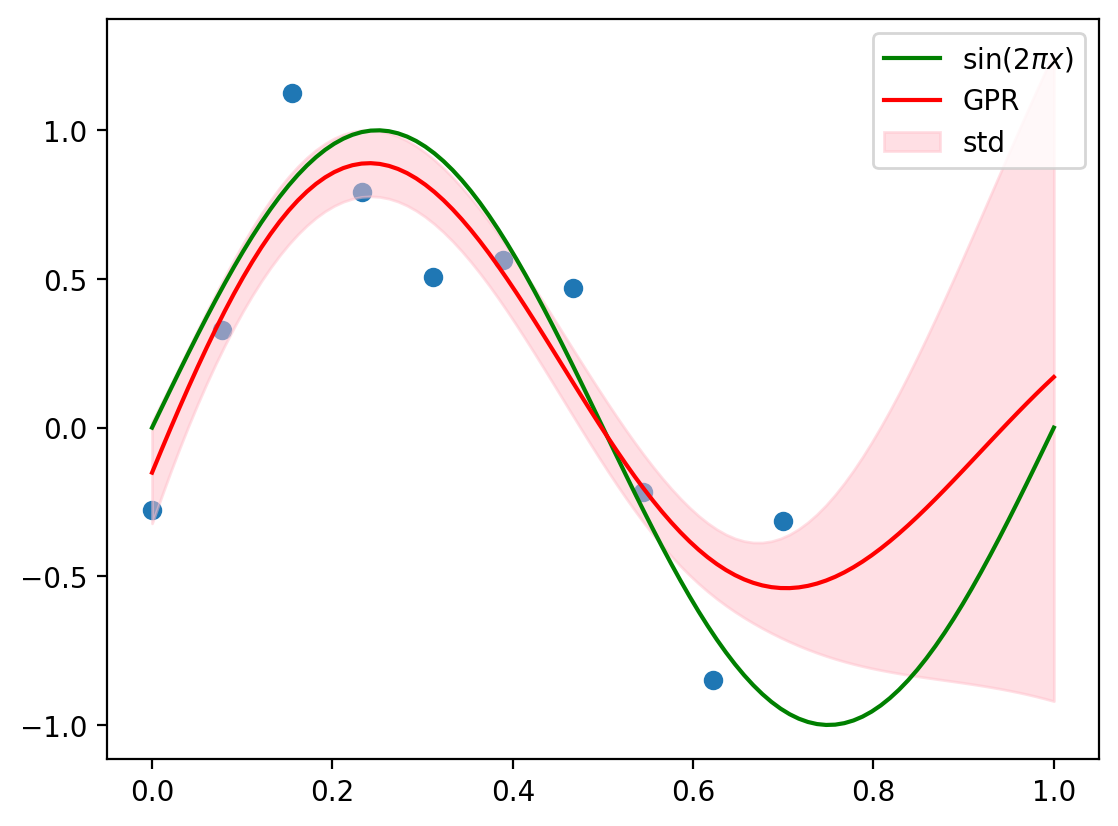

In [76]:
x_space = np.linspace(0, 1, 100)
x, t = generate_toy_data(lambda x: np.sin(2 * np.pi * x), sample_size=10, std=0.5, domain=(0, 0.7))

gpr = GaussianProcessRegression(kernel=RBF(theta=np.ones(x.ndim) * 5), beta=100)
gpr.fit(x, t)
mu, sigma = gpr.predict(x_space)

plt.scatter(x, t)
plt.plot(x_space, np.sin(2 * np.pi * x_space), color="green", label="$\sin(2\pi x)$")
plt.plot(x_space, mu, color="red", label="GPR")
plt.fill_between(x_space, mu - 2 * np.sqrt(sigma), mu + 2 * np.sqrt(sigma), alpha=0.5, color="pink", label="std")
plt.legend()
plt.show()

The extension of the Gaussian process formalism to multiple target variables $\mathbf{T} = (\mathbf{t}_1,\dots,\mathbf{t}_N)$, also known as *co-kriging* is as follows,

$$
p(\mathbf{t}_{N+1}|\mathbf{T}) = \mathcal{N}(\mathbf{t}_{N+1}|\mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{T}, c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k})
$$

which corresponds to a multi-variate Gaussian distribution.

### 6.4.3 Learning the hyperparameters

In practice, rather than fixing the covariance function, we may use a parametric family of functions and infer the parameters from the data. These parameters may govern the length scale of the correlations and the precision of the noise. Techniques for learning these hyperparameters are based on the evaluation of the likelihood function $p(\mathsf{t}|\boldsymbol\theta)$ where $\boldsymbol\theta$ denotes the hyperparameters of the Gaussian process model. The simplest approach is to make a point estimate of $\boldsymbol\theta$ by maximizing the log likelihood function. Maximization of the log-likelihood can be done using efficient gradient-based optimization algorithms, such as conjugate gradients.

The log-likelihood function for a Gaussian process regression model is easily evaluated using the standard form for a multivariate Gaussian distribution, giving

$$
\begin{aligned}
\ln p(\mathsf{t}|\boldsymbol\theta) &= \ln\mathcal{N}(\mathsf{t}|\mathbf{0},\mathbf{C}) \\
&= \ln \Bigg( \frac{1}{(2\pi)^{N/2}|\mathbf{C}|^{1/2}} \exp\Big\{-\frac{1}{2}\mathsf{t}^T \mathbf{C}^{-1}\mathsf{t} \Big\} \Bigg) \\
&= - \ln \Big( (2\pi)^{N/2}|\mathbf{C}|^{1/2} \Big) -\frac{1}{2}\mathsf{t}^T \mathbf{C}^{-1}\mathsf{t} \\
&= - \frac{N}{2}\ln(2\pi) - \frac{1}{2}\ln|\mathbf{C}| - \frac{1}{2}\mathsf{t}^T \mathbf{C}^{-1}\mathsf{t}
\end{aligned}
$$

Then, we need the gradient of the log-likelihood function with respect to the parameter vector,

$$
\begin{aligned}
\frac{\partial}{\partial\theta_i}\ln p(\mathsf{t}|\boldsymbol\theta) &=  
- \frac{1}{2}\frac{\partial}{\partial\theta_i}\ln|\mathbf{C}| - \frac{1}{2}\frac{\partial}{\partial\theta_i}\mathsf{t}^T \mathbf{C}^{-1}\mathsf{t} \\
&\overset{(C.21)}{=} - \frac{1}{2}\frac{\partial}{\partial\theta_i}\ln|\mathbf{C}| + 
\frac{1}{2}\mathsf{t}^T \mathbf{C}^{-1}\frac{\partial\mathbf{C}}{\partial\theta_i}\mathbf{C}^{-1}\mathsf{t} \\
&\overset{(C.22)}{=} - \frac{1}{2}\text{Tr}\Bigg(\mathbf{C}^{-1}\frac{\partial\mathbf{C}}{\partial\theta_i} \Bigg) + 
\frac{1}{2}\mathsf{t}^T \mathbf{C}^{-1}\frac{\partial\mathbf{C}}{\partial\theta_i}\mathbf{C}^{-1}\mathsf{t}
\end{aligned}
$$

where the evaluation of the partial derivatives of $\mathbf{C}$ depends on the covariance functions (kernels).

> Note that $\ln p(\mathsf{t}|\boldsymbol\theta)$ is a nonconvex function and it can have multiple maxima.

Moreover, we have assumed that the contribution of the predictive variance arising from the additive noise $\beta$ is a constant. For some problem, known as *heteroscedastic*, the noise variance itself depends on $\mathbf{x}$. One solution is to introduce a second Gaussian process to represent the dependence of $\beta$ on the input $\mathbf{x}$.

### 6.4.4 Automatic relevance determination

Maximizing the likelihood for learning the length-scale parameter can usefully be extended by incorporating a separate parameter for each input variable. This allows the relative importance of different inputs to be inferred from the data, which represents an example of automatic relevance determination (ARD). Therefore, we may have a kernel function of the form,

$$
k(\mathbf{x}, \mathbf{z}) = \exp\Big\{ -\frac{1}{2}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2\Big\}
$$

> As a particular parameter $η_i$ becomes small, the function becomes relatively insensitive to the corresponding input variable $x_i$. By adapting these parameters to a data set using maximum likelihood, we can detect input variables that have little effect on the predictive distribution, because the corresponding values of $η_i$ will be small. This is useful in practice because it allows irrelevant inputs to be discarded.

The partial derivative of $k(\mathbf{x}, \mathbf{z})$ with respect to $\eta_i$ is given by,

$$
\begin{aligned}
\frac{\partial}{\partial\eta_i} \exp\Big\{ -\frac{1}{2}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2\Big\} &=
\exp\Big\{ -\frac{1}{2}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2\Big\} -\frac{1}{2}\frac{\partial}{\partial\eta_i}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2 \\
&= \exp\Big\{ -\frac{1}{2}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2\Big\} -\frac{1}{2}\frac{\partial}{\partial\eta_i}\sum_{i=1}^N\eta_i(x_i - z_i)^2 \\
&= \exp\Big\{ -\frac{1}{2}||\boldsymbol\eta(\mathbf{x} - \mathbf{z})||^2\Big\} -\frac{1}{2}(x_i - z_i)^2
\end{aligned}
$$

-- Iterations 0: 106.62105480846333
-- Iterations 100: 16.73499899402815
-- Iterations 200: 10.900800926148609
-- Iterations 300: 8.352834973210353
-- Iterations 400: 6.79206345414369
-- Iterations 500: 5.658719022565627
-- Iterations 600: 4.743421926165226
-- Iterations 700: 3.953116694126315
-- Iterations 800: 3.259548576802345
-- Iterations 900: 2.6734093844879148


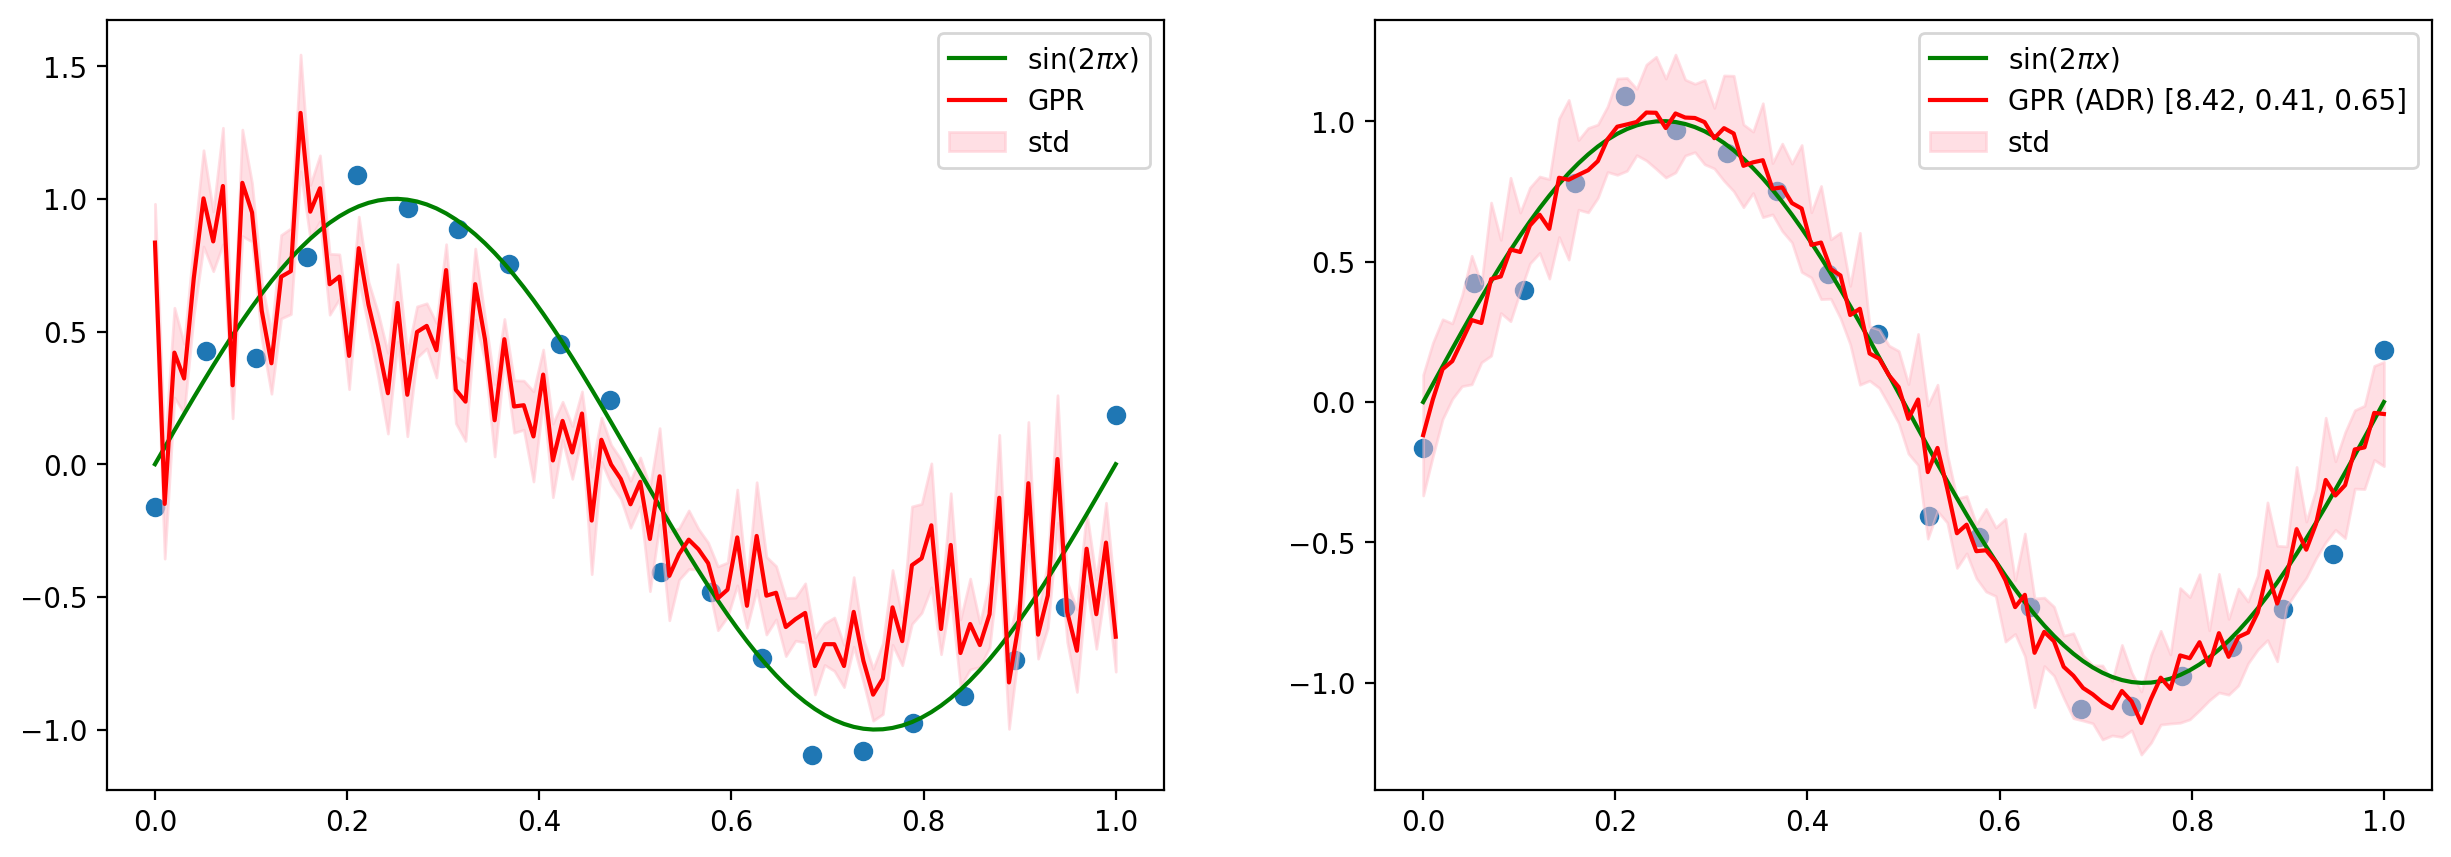

In [189]:
x0 = np.linspace(0, 1, 20)
x1 = x0 + np.random.normal(scale=0.1, size=20)
x2 = np.random.normal(scale=0.1, size=20)
t = np.sin(2 * np.pi * x0) + np.random.normal(scale=0.1, size=20)
x = np.vstack((x0, x1, x2)).T

x0 = np.linspace(0, 1, 100)
x1 = x0 + np.random.normal(scale=0.1, size=100)
x2 = np.random.normal(scale=0.1, size=100)
x_space = np.vstack((x0, x1, x2)).T

model = GaussianProcessRegression(kernel=RBF(np.array([1., 1., 1.])), beta=100)
model.fit(x, t)
mu, sigma = model.predict(x_space)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], t)
plt.plot(x_space[:, 0], np.sin(2 * np.pi * x_space[:, 0]), color="green", label="$\sin(2\pi x)$")
plt.plot(x_space[:, 0], mu, color="red", label="GPR")
plt.fill_between(x_space[:, 0], mu - 2 * np.sqrt(sigma), mu + 2 * np.sqrt(sigma), alpha=0.5, color="pink", label="std")
plt.legend()

model = GaussianProcessRegression(kernel=RBF(np.array([1., 1., 1.])), beta=100)
model.fit(x, t, 1000, 0.001)
mu_adr, sigma_adr = model.predict(x_space)

plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], t)
plt.plot(x_space[:, 0], np.sin(2 * np.pi * x_space[:, 0]), color="green", label="$\sin(2\pi x)$")
plt.plot(x_space[:, 0], mu_adr, color="red", label=f"GPR (ADR) {[np.round(p, 2) for p in model._kernel.theta.tolist()]}")
plt.fill_between(x_space[:, 0], mu_adr - 2 * np.sqrt(sigma_adr), mu_adr + 2 * np.sqrt(sigma_adr), alpha=0.5, color="pink", label="std")
plt.legend()

plt.show()

### 6.4.5 Gaussian process for classification

Similar to logistic regression, we can adapt Gaussian process to classification problems by transforming the output using an approriate nonlinear activation function. Consider a binary problem with a target variable $t\in\{0, 1\}$. If we define a Gaussian process over a function $a(\mathbf{x})$ and then transform the function using a logistic sigmoid $y=\sigma(a)$, we obtain a non-Gaussian stochastic process over functions $y(\mathbf{x}) \in (0, 1)$.

As an example, we plot a sample from a Gaussian process prior over functions $a(\mathbf{x})$ and the resulting transformation using the logistic sigmoid function.

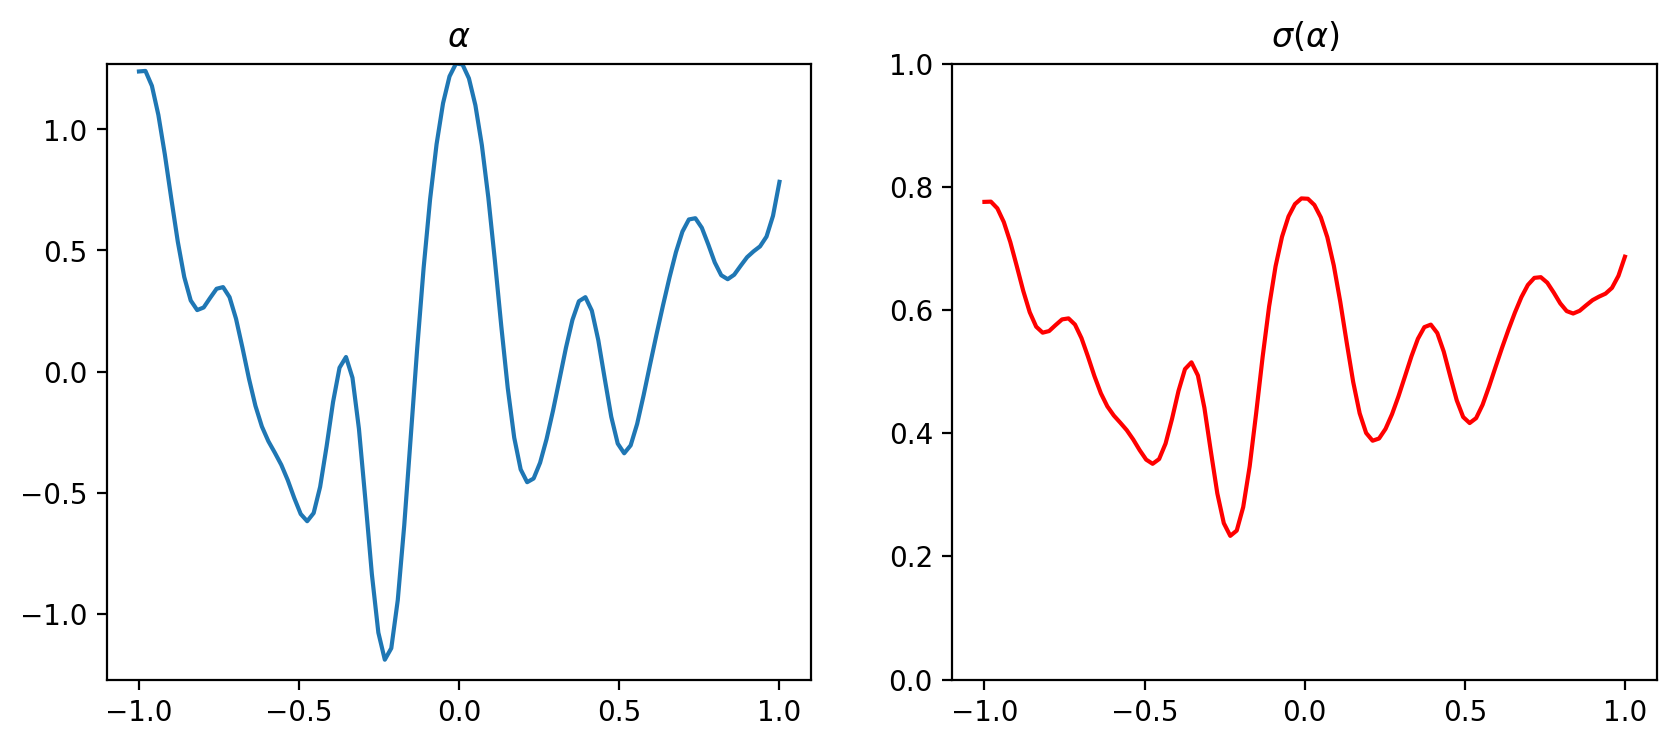

In [63]:
x_space = np.linspace(-1, 1, 100)

def logistic(x):
    return (1 / (1 + np.exp(-x)))

k = RBF(theta=np.ones(x_space.ndim) * 100)
a = np.random.multivariate_normal(np.zeros(x_space.shape), k(x_space, x_space), 1)[0]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x_space, a)
bound = max(np.abs(a.min()), a.max())
plt.ylim(-bound, bound)
plt.title("$\\alpha$")

plt.subplot(1, 2, 2)
plt.plot(x_space, logistic(a), color="red")
plt.ylim(0, 1)
plt.title("$\sigma(\\alpha)$")

plt.show()

Our goal is to determine the predictive distribution $p(t_{N+1}|\mathsf{t})$. To that end, we introduce a Gaussian process prior over the vector $\mathbf{a}_{N+1} = [a(\mathbf{x}_1),\dots,a(\mathbf{x}_{N+1})]^T$, which in turn, defines a non-Gaussian process over $\mathsf{t}_{N+1}$. Then, by conditioning on the training data $\mathsf{t}_N$ we obtain the required predictive distribution. The Gaussian process prior for $\mathbf{a}_{N+1}$ takes the form

$$
p(\mathbf{a}_{N+1}) = \mathcal{N}(\mathbf{a}_{N+1}|\mathbf{0}, \mathbf{C}_{N+1})
$$

Unlike the regression case, the covariance matrix no longer includes a noise term because we assume that all training data points are correctly labelled. However, for numerical reasons it is convenient to introduce a noise-like term governed by a parameter $\beta$ that ensures that the covariance matrix is positive definite. Thus, the covariance matrix has elements given by,

$$
C_{nm} = k(\mathbf{x}_n, \mathbf{x}_m) + \beta\delta_{nm}
$$

For a binary classification problem, it is sufficient to predict $p(t_{N+1} = 1|\mathsf{t}_N)$ because $p(t_{N+1} = 0|\mathsf{t}_N) = 1 - p(t_{N+1} = 1|\mathsf{t}_N)$. The required predictive distribution is given by,

$$
p(t_{N+1} = 1|\mathsf{t}_N) = \int p(t_{N+1} = 1|a_{N+1})p(a_{N+1}|\mathsf{t}_N) da_{N+1} = \int \sigma(a_{N+1})p(a_{N+1}|\mathsf{t}_N) da_{N+1}
$$

This integral is analytically intractable, and so may be approximated.

#### 6.4.7 Connection to neural networks

In a Bayesian neural network, the prior distribution over the parameter vector $\mathbf{w}$, in conjunction with the network function $f(\mathbf{x}, \mathbf{w})$, produces a prior distribution over functions from $y$. It has been shown that for a broad class of prior distributions over $\mathbf{w}$, the distribution of functions generated by the neural network tends to a Gaussian process in the hidden units limit of $M \rightarrow \infty$. Note however, that in this limit, the output variables of the neural network become independent. On the other hand, typical neural network outputs share the hidden units and so the hidden unit weights are influenced by all of the output variables. This property is therefore lost in the Gaussian process limit.